In [300]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../") 
import models.utility as utils

In [301]:
import spacy
import html
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import geopy
import gzip
from scipy import deg2rad
import random
import pandas as pd
import jsonlines
import string
import re
import requests
import os
from collections import Counter

import sklearn.linear_model as linear_model
import sklearn.neighbors as neighbors
import sklearn.gaussian_process as gaussian_process
import sklearn.discriminant_analysis as discriminant_analysis
import sklearn.svm as svm
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics
sns.set()

In [2]:
nlp = spacy.load('en_core_web_md')

In [302]:
raw_articles, raw_annotations, raw_locations = utils.load_dataset()

articles count: 9959
annotations count: 3221
locations count: 3562


In [4]:
annotation_histogram = Counter()
publisher_histogram = Counter()
for i, raw_doc in enumerate(raw_articles):
    annotation_histogram[len(raw_doc["annotation_uri"])] += 1
    publisher_histogram[raw_doc["publisher"]] += 1


Let's display the distribution of annotations/locations over the article dataset.

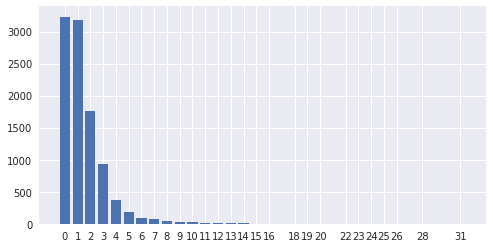

In [6]:
fig = plt.figure(figsize=(8,4))
plt.bar(annotation_histogram.keys(), annotation_histogram.values(),tick_label=[k for k in annotation_histogram.keys()]);


Likewise for the distribution of publishers:

In [11]:
c = 30
print(f"{c} most common publishers: ")
for k,v in publisher_histogram.most_common(c):
    print(k.ljust(35)," | count:" ,v)

30 most common publishers: 
www.birminghammail.co.uk             | count: 191
mirror                               | count: 190
www.manchestereveningnews.co.uk      | count: 181
dailyrecord                          | count: 156
www.coventrytelegraph.net            | count: 156
The Courier                          | count: 154
www.liverpoolecho.co.uk              | count: 152
The Northern Echo                    | count: 143
Eastern Daily Press                  | count: 131
www.walesonline.co.uk                | count: 129
HeraldScotland                       | count: 128
www.chroniclelive.co.uk              | count: 126
Bournemouth Echo                     | count: 126
www.yorkshirepost.co.uk              | count: 123
Evening Times                        | count: 122
www.thestar.co.uk                    | count: 106
This Is Local London                 | count: 98
East Anglian Daily Times             | count: 92
www.yorkshireeveningpost.co.uk       | count: 90
www.glasgowlive.co.uk    

We notice that some publisher may belong to the same group but have different name. for example, "birminghammail" and "birminghammail.com"

We're going to clean up the publishers name to possibly

In [235]:
[a for a in raw_articles if "The Charlton Champion" == a["publisher"]]

[{'iid': 'f020439f-723d-4eec-8bec-9a9309dc1749',
  'lastModifiedTime': 1530456309000,
  'publisher': 'The Charlton Champion',
  'published_time': None,
  'annotation_uri': ['5e5f51d83ca0e75f33f8811727cc90e3',
   '76defb7d20d73da27d65eb10bd976d2a'],
  'id': 'f020439f-723d-4eec-8bec-9a9309dc1749',
  'url': 'https://charltonchampion.co.uk/2018/07/01/rockwell-returns-controversial-charlton-riverside-scheme-to-be-heard-on-9-july/',
  'articleid': None,
  'previous_id': None,
  'type': 'articles',
  'title': 'Rockwell returns: Controversial Charlton Riverside scheme to be heard on 9 July',
  'cleantitle': None,
  'description': 'Plans to redevelop the VIP Trading Estate by developer Rockwell are to go before Greenwich Council’s Planning Board on Monday 9th July,\xa0the original hearing in April being deferred until afte…',
  'body': 'Plans to redevelop the VIP Trading Estate by developer Rockwell are to go before Greenwich Council’s Planning Board on Monday 9th July, the original hearing in 

In [13]:
set([a["publisher"] for a in raw_articles if "birm" in a["publisher"].lower()])

{'birminghammail', 'www.birminghammail.co.uk', 'www.birminghampost.co.uk'}

In [15]:
publishers = set([a["publisher"] for a in raw_articles])

In [16]:
clean_publisher_histogram = Counter()
for i, raw_doc in enumerate(raw_articles):
    clean_publisher_histogram[utils.clean_publisher(raw_doc["publisher"])] += 1

In [238]:
print(len(publisher_histogram))
print(len(clean_publisher_histogram))
n = 80
print(len([p for p, c in publisher_histogram.items() if c > n]))
print(len([p for p, c in clean_publisher_histogram.items() if c > n]))

384
378
23
24


In [18]:

print(f"{c} most common publishers: ")
for k,v in clean_publisher_histogram.most_common(c):
    print(k.ljust(35)," | count:" ,v)

30 most common publishers: 
birminghammail                       | count: 200
mirror                               | count: 190
manchestereveningnews                | count: 181
dailyrecord                          | count: 156
coventrytelegraph.net                | count: 156
thecourier                           | count: 154
liverpoolecho                        | count: 152
thenorthernecho                      | count: 143
easterndailypress                    | count: 131
walesonline                          | count: 130
heraldscotland                       | count: 128
chroniclelive                        | count: 126
bournemouthecho                      | count: 126
yorkshirepost                        | count: 123
eveningtimes                         | count: 122
belfastlive                          | count: 119
thestar                              | count: 106
thisislocallondon                    | count: 98
eastangliandailytimes                | count: 92
yorkshireeveningpost    

In [216]:
raw_doc = raw_articles[99]
print(pretty_dict(raw_doc))

{
    "iid": "ec5c176d-ceb4-46dc-ae68-60bac4056753",
    "lastModifiedTime": 1530469114000,
    "publisher": "The Courier",
    "published_time": null,
    "annotation_uri": [
        "f99c3a35f03a8eb7f3b0bb044b8e5506",
        "5c8ad4f4220ed87d24fbdc261c243091",
        "09b4a5eed6a1e20bb5b5088055163607"
    ],
    "id": "ec5c176d-ceb4-46dc-ae68-60bac4056753",
    "url": "https://www.thecourier.co.uk/news/uk-world/680465/russia-fans-party-hard-after-team-knocks-spain-out-of-world-cup/",
    "articleid": null,
    "previous_id": null,
    "type": "articles",
    "title": "Russia fans party hard after team knocks Spain out of World Cup",
    "cleantitle": null,
    "description": "Russia fans wept and leapt for joy as Moscow went into meltdown after their football team knocked Spain out of the World Cup on penalties.",
    "body": "New data has shown the Queensferry Crossing is improving the reliability of crossing the Forth. As the heatwave continues to bake many parts of the UK, zooke

In [21]:
limit = 10
for i, raw_doc in enumerate(raw_articles):
    print(f"{i}".ljust(2), " | ", raw_doc["publisher"].ljust(35), " | ", raw_doc["id"], " | ", summarize_text(raw_doc["title"]))
    if limit and limit <= i:
        break

0   |  www.nwemail.co.uk                    |  9764d074-d5e1-44ee-99be-4bf910d2ded3  |  Britain told it must follow EU...- The Mail
1   |  www.rotherhamadvertiser.co.uk        |  f405538d-46a2-4edf-96cb-18e526303c19  |  Full Rotherham United 2018/19 ...xture list
2   |  www.rotherhamadvertiser.co.uk        |  cb4bf1f6-c7dd-4ca0-848f-edf564bec04a  |  Full Rotherham United 2018/19 ...xture list
3   |  www.rotherhamadvertiser.co.uk        |  ac8bd1b3-a021-48f2-9a7d-9fc48f5c0eda  |  Championship campaign starts a... Brentford
4   |  www.rotherhamadvertiser.co.uk        |  1d8e6a9c-5b9f-4a2e-9765-9bee37c650a1  |  Championship campaign starts a... Brentford
5   |  www.nwemail.co.uk                    |  c0a38821-1df3-493b-ac9f-0191e4dd4992  |  Transport Secretary Chris Gray...- The Mail
6   |  www.timesandstar.co.uk               |  b7774edf-88dc-4dd5-90d6-8beb58c9896d  |  Transport Secretary Chris Gray...mes & Star
7   |  www.whitehavennews.co.uk             |  46e9c8e2-1cac-4414-a302-bd13c

In [96]:
def extract_vector(raw_document, aggregate=False):
    publisher = raw_document["publisher"]
    doc = nlp(html.unescape(raw_document["body"]))
    entities = []
    vector_list = []
    for ent in doc.ents:
        if ent.label_ in ["GPE", "ORG", "LOC", "FAC"]: 
            entities.append((publisher, ent.text, ent.label_))
            vector_list.append(ent.vector)
    vectors = np.stack(vector_list)
    if aggregate:
        vectors = np.atleast_2d(vectors.mean(axis=0))
        entities = [publisher]
    return entities, vectors

In [97]:
_, vector = extract_vector(raw_articles[0], aggregate=True)

In [99]:
entities = []
vector_list = []
limit = None
current_pub = None
for i, raw_doc in enumerate(raw_articles):
    # if raw_doc["publisher"] != current_pub:
    #    current_pub = raw_doc["publisher"]
        #print(current_pub)
    doc_entities, doc_vectors = extract_vector(raw_doc, aggregate=True)
    entities.extend(doc_entities)
    vector_list.append(doc_vectors)
    
    if limit and limit <= i:
        break
        
vectors = np.concatenate(vector_list, axis=0)


In [23]:
raw_locations[0]

{'iid': '7fa1c86a-591d-46ea-a1f7-fec79e667b22',
 'council_annotation_uri': '0280893123d7785441eff9fa1641170b',
 'county': 'Derbyshire',
 'local_government_area': 'City of Derby',
 'nuts_region': 'East Midlands',
 'lng': -1.44377,
 'lat': 52.91562,
 'country': 'England',
 'name': 'Pride Park',
 'lastModifiedTime': 1516791066877,
 'origin_type': 'Other Settlement',
 'annotation_uri': ['be48009bf7ec91d46983f1044db47f76'],
 'id': 'ec79cba6-d6a6-485d-ab33-65ac0412f54b',
 'type': 'locations',
 'postcode_sector': 'DE24 8'}

In [232]:
origin_types = set()
for annotation in raw_annotations:
    types = annotation["origin_types"] or []
    for origin_type in types:
        #print(origin_type)
        origin_types.add(origin_type)
print(origin_types)

{'ArchitecturalStructure', 'NaturalPlace', 'Place', 'PeriodicalLiterature', 'Station', 'Mountain', 'ShoppingMall', 'School', 'City', 'College', 'SportsTeam', 'SiteOfSpecialScientificInterest', 'Region', 'RouteOfTransportation', 'SportFacility', 'Country', 'Infrastructure', 'Newspaper', 'BodyOfWater', 'EducationalInstitution', 'Legislature', 'Racecourse', 'Settlement', 'Hospital', 'Island', 'Village', 'MilitaryPerson', 'AdministrativeRegion', 'CricketGround', 'Park', 'PopulatedPlace', 'Saint', 'Stream', 'Lake', 'HistoricPlace', 'Venue', 'Town', 'Person', 'Organisation', 'Road', 'Location', 'Building', 'Agent', 'Holiday', 'PoliticalParty', 'River', 'MusicalWork', 'RaceTrack', 'Theatre', 'Jurisdiction>', 'Album', 'Stadium', 'SoccerClub', 'WrittenWork', 'MilitaryStructure', 'Cleric', 'HistoricBuilding', 'Work', 'Royalty', 'Company'}


We're going to obtain the lat/long for each publications.

In [26]:
uri_index = utils.get_annotation_uri_index(raw_annotations, raw_locations)
location_index = utils.get_location_index(raw_locations)

In [111]:
pub_feature_set = []
columns = ["publisher", "lat", "lng", "origin_type", "name", "nuts_region", "local_government_area", "id"]
for article in raw_articles:
    for annotation in article["annotation_uri"]:
        if annotation in uri_index.keys():
            locations = uri_index[annotation]["locations"]
            for location in locations:
                pub_feature_set.append((utils.clean_publisher(article["publisher"]),  
                                        *(location[c] for c in columns[1:])))
pub_feature_set = pd.DataFrame(pub_feature_set, columns=columns)

In [29]:
birminghammail = pub_feature_set[pub_feature_set["publisher"] == "birminghammail"]

In [31]:
birminghammail["nuts_region"].unique()

array(['London', 'West Midlands', 'South West', 'South East', 'Eastern',
       'Yorkshire and the Humber', 'East Midlands', 'North East',
       'North West', 'Wales'], dtype=object)

We notice that Eastern appears to map to East of England.

In [34]:
publishers = pub_feature_set["publisher"].unique()
palette = {pub: pal for pub, pal in zip(publishers, sns.palettes.color_palette(n_colors=len(publishers)))}

In [62]:
pub_feature_set.groupby("publisher")["publisher"].count()["dailypost"]

59

In [67]:
n = 100
publishers.sort()
large_publishers = publishers[pub_feature_set.groupby("publisher")["publisher"].count() > n]

In [112]:
pub_feature_set.sample(30)

,publisher,lat,lng,origin_type,name,nuts_region,local_government_area,id
11182,dailyecho,50.90489,-1.40431,City,Southampton,South East,City of Southampton,55b65ad7-a954-44a0-9b2a-442505235d98
7428,birminghampost,52.47928,-1.90294,City,Birmingham,West Midlands,Birmingham District,fbe7bb85-5ee9-4172-955c-ec2f9b9ac3b4
9027,becclesandbungayjournal,52.09317,1.31873,Town,Woodbridge,Eastern,Suffolk Coastal District,35f43cdc-05ee-4ebe-ba27-a97673a9cd83
9758,louthleader,53.36706,-0.00394,Town,Louth,East Midlands,East Lindsey District,28b4138d-7068-472d-8a80-30ecb8367b4a
7249,glasgowlive,55.83772,-4.27286,Suburban Area,Strathbungo,Scotland,Glasgow City,07a6d428-b2a9-4382-9675-5fccee369607
4102,lancasterandmorecambecitizen,53.73106,-2.52533,Suburban Area,Cherry Tree,North West,Blackburn with Darwen,97c5d7af-8174-437a-9ddf-3418d5989c67
12774,lancasterandmorecambecitizen,53.88076,-2.35359,Hamlet,Worston,North West,Ribble Valley District,d508d8d0-a34e-400d-89b8-6b1c83534dcd
13154,northwales,53.18467,-3.02549,Village,Hawarden,Wales,Flintshire / Sir y Fflint,867a804d-c778-400b-9370-b26f5caaf08b
3734,southyorkshiretimes,53.51570,-1.08908,Other Settlement,Doncaster Common,Yorkshire and the Humber,Doncaster District,a02c77a8-3e7b-43fb-b706-e7191327c4bd
11578,wiltsandgloucestershirestandard,51.74497,-2.20745,Suburban Area,Stroud Hill,South West,Stroud District,41d429f4-aebc-492b-8460-6a2583faa6bb


In [70]:
large_publishers

array(['belfastlive', 'birminghammail', 'blackpoolgazette',
       'bournemouthecho', 'chroniclelive', 'coventrytelegraph.net',
       'dailyrecord', 'devonlive', 'eastangliandailytimes',
       'easterndailypress', 'gazettelive', 'getsurrey', 'glasgowlive',
       'inyourarea', 'lep', 'liverpoolecho', 'manchestereveningnews',
       'mirror', 'plymouthherald', 'somersetlive', 'theargus',
       'thenorthernecho', 'thestar', 'thisislocallondon', 'walesonline',
       'yorkshirepost'], dtype=object)

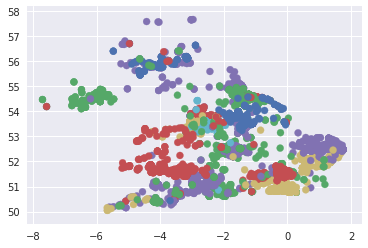

In [278]:
for pub in large_publishers:
    features = pub_feature_set[pub_feature_set["publisher"] == pub]
    color_map = [palette[p] for p in features["publisher"]]
    plt.scatter(features["lng"], features["lat"], color=color_map);


In [72]:
geolocator = geopy.Nominatim()

In [75]:
geolocator.geocode("West Midlands")

Location(West Midlands, Moyses Croft, Sandwell, West Midlands Combined Authority, West Midlands, England, B16, UK, (52.5050033, -1.96439612333127, 0.0))

In [234]:
pub = large_publishers[1]
features = pub_feature_set[pub_feature_set["publisher"] == pub]
features.sample(5)

,publisher,lat,lng,origin_type,name,nuts_region,local_government_area,id
711,birminghammail,52.32330,-1.66969,Village,Five Ways,West Midlands,Warwick District,2c293a16-dbb6-4dac-8641-ffc9d34f2031
923,birminghammail,52.47457,-1.84836,Suburban Area,Bordesley Green,West Midlands,Birmingham District,ee92b158-ebcb-4433-8c44-2bca0f599933
2267,birminghammail,52.39672,-1.98450,Suburban Area,Longbridge,West Midlands,Birmingham District,c8e557da-befa-4e7c-a67c-37946ba1fac1
1411,birminghammail,52.47928,-1.90294,City,Birmingham,West Midlands,Birmingham District,fbe7bb85-5ee9-4172-955c-ec2f9b9ac3b4
8473,birminghammail,52.54124,-2.03975,Town,Tipton,West Midlands,Sandwell District,3fa96e29-6102-4008-b262-fc7380994b25


In [235]:
known_ids = set(features["id"].values)
all_ids = set(location_index.keys())

In [236]:
'b3e85189-5e04-4436-bed6-f92a4a9cc6c9' in location_index.keys()

True

In [237]:
acceptable_ids = all_ids.difference(known_ids)

In [239]:
len(all_ids) == len(known_ids) + len(acceptable_ids)

True

In [240]:
selected_ids = random.choices(list(acceptable_ids), k=features.shape[0])

In [241]:
def get_geoloc(selected_ids, location_index, locations):
    geo_loc = []
    for loc_id in selected_ids:
        location = locations[location_index[loc_id]]
        geo_loc.append((location["lat"], location["lng"], loc_id))
    geo_loc = pd.DataFrame(geo_loc, columns=["lat", "lng", "id"])
    return geo_loc

In [242]:
false_sample = get_geoloc(selected_ids, location_index, raw_locations)
false_sample["Y"] = 0

In [243]:
true_sample = features[["lat", "lng", "id"]].copy()
true_sample["Y"] = 1

In [244]:
sample = pd.concat((true_sample, false_sample))

In [245]:
clf = linear_model.LogisticRegression()

In [246]:
train, test = model_selection.train_test_split(sample.drop("id", 1), test_size=0.3)

In [247]:
model = clf.fit(train[["lat", "lng"]], y=train["Y"])

In [248]:
y_hat = model.predict(test[["lat", "lng"]])

In [249]:
metrics.accuracy_score(test["Y"], y_hat)

0.34552845528455284

In [250]:
print(metrics.classification_report(test["Y"], y_hat))

             precision    recall  f1-score   support

          0       0.39      0.70      0.50       117
          1       0.08      0.02      0.04       129

avg / total       0.23      0.35      0.26       246



In [270]:
    known_ids = set(features["id"].values)
    all_ids = set(location_index.keys())
    acceptable_ids = all_ids.difference(known_ids)
    selected_ids = random.choices(list(acceptable_ids), k=features.shape[0])
    negative_sample = get_geoloc(selected_ids, location_index, raw_locations)
    negative_sample["Y"] = 0
    positive_sample = features[["lat", "lng", "id"]].copy()
    positive_sample["Y"] = 1
    sample = pd.concat((positive_sample, negative_sample))

    (X_train, Y_train), (X_test, Y_test) = model_selection.train_test_split((X.drop("id", 1), Y), test_size=0.3)

ValueError: not enough values to unpack (expected 2, got 1)

In [274]:
 model_selection.train_test_split?

Signature: model_selection.train_test_split(*arrays, **options)
Docstring:
Split arrays or matrices into random train and test subsets

Quick utility that wraps input validation and
``next(ShuffleSplit().split(X, y))`` and application to input data
into a single call for splitting (and optionally subsampling) data in a
oneliner.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
    matrices or pandas dataframes.

test_size : float, int, None, optional
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is set to the
    complement of the train size. By default, the value is set to 0.25.
    The default will change in version 0.21. It will remain 0.25 only
    if ``train_size`` is unspecified, ot

In [275]:
def evaluate(features, clf):
    known_ids = set(features["id"].values)
    all_ids = set(location_index.keys())
    acceptable_ids = all_ids.difference(known_ids)
    selected_ids = random.choices(list(acceptable_ids), k=features.shape[0])
    negative_sample = get_geoloc(selected_ids, location_index, raw_locations)
    negative_sample["Y"] = 0
    positive_sample = features[["lat", "lng", "id"]].copy()
    positive_sample["Y"] = 1
    sample = pd.concat((positive_sample, negative_sample))
    X = sample.drop("Y", axis=1)
    Y = sample["Y"]
    train, test = model_selection.train_test_split(sample.drop("id", 1), test_size=0.3)
    model = clf.fit(train[["lat", "lng"]], y=train["Y"])
    y_hat = model.predict(test[["lat", "lng"]])
    print(metrics.confusion_matrix(test["Y"], y_hat))
    print(metrics.classification_report(test["Y"], y_hat))

In [290]:
clf = svm.SVC( degree=2)
for pub in large_publishers:
    features = pub_feature_set[pub_feature_set["publisher"] == pub]
    print("---------------------------------------------")
    print(f"Publisher: {pub}")
    evaluate(features, clf)

---------------------------------------------
Publisher: belfastlive
[[35  0]
 [ 5 26]]
             precision    recall  f1-score   support

          0       0.88      1.00      0.93        35
          1       1.00      0.84      0.91        31

avg / total       0.93      0.92      0.92        66

---------------------------------------------
Publisher: birminghammail
[[117   2]
 [ 16 111]]
             precision    recall  f1-score   support

          0       0.88      0.98      0.93       119
          1       0.98      0.87      0.92       127

avg / total       0.93      0.93      0.93       246

---------------------------------------------
Publisher: blackpoolgazette
[[37  8]
 [ 5 28]]
             precision    recall  f1-score   support

          0       0.88      0.82      0.85        45
          1       0.78      0.85      0.81        33

avg / total       0.84      0.83      0.83        78

---------------------------------------------
Publisher: bournemouthecho
[[65  